/var/folders/xd/6b7x17ts5b7612cqwyl3b63m0000gp/T/ipykernel_73063/1184003351.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  stiffness = np.trapz(dphi(i, quad_x) * dphi(j, quad_x), quad_x)
/var/folders/xd/6b7x17ts5b7612cqwyl3b63m0000gp/T/ipykernel_73063/1184003351.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass = np.trapz(phi(i, quad_x) * phi(j, quad_x), quad_x)
/var/folders/xd/6b7x17ts5b7612cqwyl3b63m0000gp/T/ipykernel_73063/1184003351.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bvec[j] = np.trapz(quad_x**2 * phi(j, quad_x), quad_x)


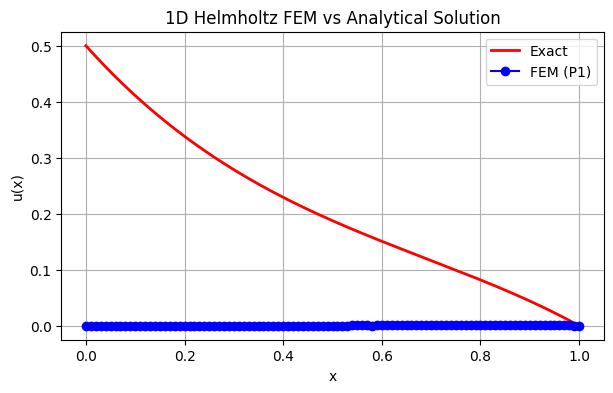

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve

# -----------------------------
# Problem parameters
# -----------------------------
n = 100                  # number of elements
omega = 2.0
a, b = 0.0, 1.0

# FEM mesh
nodes = np.linspace(a, b, n+1)
h = nodes[1] - nodes[0]

# Fine quadrature grid (IMPORTANT)
quad_x = np.linspace(a, b, 3001)

# -----------------------------
# Analytical solution
# -----------------------------
def u_exact(x, omega):
    denom = np.sinh(omega)

    C = (1/omega**2 + 2/omega**4) / denom

    return (
        C * (np.sinh(omega*(1-x)) - np.sinh(omega*x))
        + x**2 / omega**2
        + 2.0 / omega**4
    )


# -----------------------------
# FEM basis functions (P1)
# -----------------------------
def phi(i, x):
    return np.maximum(1 - np.abs(x - nodes[i]) / h, 0.0)

def dphi(i, x):
    vals = np.zeros_like(x)

    left = (nodes[i] - h <= x) & (x < nodes[i])
    right = (nodes[i] <= x) & (x <= nodes[i] + h)

    vals[left] = 1.0 / h
    vals[right] = -1.0 / h

    return vals

# -----------------------------
# Assemble FEM system
# -----------------------------
A = lil_matrix((n+1, n+1))
bvec = np.zeros(n+1)

for i in range(n+1):
    for j in range(n+1):
        if abs(i - j) <= 1:
            stiffness = np.trapz(dphi(i, quad_x) * dphi(j, quad_x), quad_x)
            mass = np.trapz(phi(i, quad_x) * phi(j, quad_x), quad_x)
            A[i, j] = stiffness + omega**2 * mass

for j in range(n+1):
    bvec[j] = np.trapz(quad_x**2 * phi(j, quad_x), quad_x)

# -----------------------------
# Dirichlet BCs: u(0)=u(1)=0
# -----------------------------
A[0, :] = 0.0
A[0, 0] = 1.0
bvec[0] = 0.0

A[-1, :] = 0.0
A[-1, -1] = 1.0
bvec[-1] = 0.0

# -----------------------------
# Solve FEM system
# -----------------------------
u_fem = spsolve(A.tocsr(), bvec)

# -----------------------------
# Plot FEM vs analytical
# -----------------------------
xx = np.linspace(a, b, 500)

plt.figure(figsize=(7, 4))
plt.plot(xx, u_exact(xx, omega), 'r-', linewidth=2, label="Exact")
plt.plot(nodes, u_fem, 'bo-', label="FEM (P1)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("1D Helmholtz FEM vs Analytical Solution")
plt.legend()
plt.grid(True)
plt.show()
